<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/b__wide/experiments/b_wide/Implement/tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [A-2]環境構築

In [1]:
#@title gdrive マウント
from google.colab import drive
from os import path
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")

Mounted at /content/drive


In [3]:
import os
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)

shelf = '/content/drive/MyDrive/colab/seed'
if not os.path.exists(shelf):
  os.mkdir(shelf)

In [4]:
#@title データフォーマットを規定
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値
  
format1 = video_format()

# [A-1]データ取得・整形

## [A-1-1]データ取得

In [ ]:
# データパス
path_data = "/content/drive/MyDrive/CM_vid2019"

In [ ]:
#@title 教師ラベルを規定
# ラベルの集合とディレクトリ名の対応(既知なので)
LABEL = {
    'other' : 0, 
    'food' : 1,
    'car' : 2,
    'cosme' : 3
    }

In [ ]:
#@title データの取得
from os import path
from os import listdir
import cv2
import numpy as np
import math

class VIDEO:
  data = 'original content'
  label = 'label for learning'
  path = 'path of data'
  WIDTTH = 'width of original frame'
  HEIGHT = 'height of original frame'
  FRAME_SIZE = 'number of all frames in a video'
  FPS = 'FRAME_SIZE / play time(second)'
  TIME = 'play time'
  def __init__ (self, path_video, label):
    self.data = cv2.VideoCapture(path_video) # 動画の内容
    self.label = label # 教師ラベル

    self.path = path_video # 動画の場所 
    self.WIDTH = self.data.get(cv2.CAP_PROP_FRAME_WIDTH) # フレームの幅
    self.HEIGHT = self.data.get(cv2.CAP_PROP_FRAME_HEIGHT) # フレームの高さ
    self.FRAME_SIZE = self.data.get(cv2.CAP_PROP_FRAME_COUNT) # フレームの数
    self.FPS = self.data.get(cv2.CAP_PROP_FPS) # FPS = フレーム数 / 秒数：(Frame Per Second)
    # 時間
    try:
      self.time = round(self.FRAME_SIZE / self.FPS)
    except ZeroDivisionError:
      self.time = None
      
except_file = '.DS_Store'
videos = []

sw.start()
# 教師ラベル毎に読み込んでいく（仕様により。仕様：教師ラベルのディレクトリがファイルを内包）
for dir_label in LABEL:
  header = LABEL[dir_label]
  package = str(header) + '.' + dir_label
  path_dir_label = path.join(path_data, package)
  print(path_dir_label, 
        "\n-------------------------------------------------------------------------------------------")
  set_file = listdir(path_dir_label)
  # ファイルごとになっている
  for file in set_file:
    if not file == except_file:
      path_file = path.join(path_dir_label, file)
      print(path_file)
      # ファイルからビデオ情報を取得
      video = VIDEO(path_file, dir_label)
      # 格納
      videos.append(video)
  print("========================================================\n\n ")

print("SUM : ", len(videos))


/content/drive/MyDrive/CM_vid2019/0.other 
-------------------------------------------------------------------------------------------
/content/drive/MyDrive/CM_vid2019/0.other/Yamato_宅急便コンパクト.mpg
/content/drive/MyDrive/CM_vid2019/0.other/ZURICH_保険_チューリッヒ保険_30秒.mp4
/content/drive/MyDrive/CM_vid2019/0.other/刑事7人[2].mp4
/content/drive/MyDrive/CM_vid2019/0.other/メットライフ生命_MetLife.mp4
/content/drive/MyDrive/CM_vid2019/0.other/刑事7人.mp4
/content/drive/MyDrive/CM_vid2019/0.other/XFLAG_ゲーム_モンスターストライク超獣神祭.mp4
/content/drive/MyDrive/CM_vid2019/0.other/ソフラン_クイーンズシルク.mp4
/content/drive/MyDrive/CM_vid2019/0.other/ダイソン_掃除_dyson v8.mp4
/content/drive/MyDrive/CM_vid2019/0.other/東宝_青空エール.mp4
/content/drive/MyDrive/CM_vid2019/0.other/大東電機工業_THRIVE.mp4
/content/drive/MyDrive/CM_vid2019/0.other/au_Wallet_30秒.mpg
/content/drive/MyDrive/CM_vid2019/0.other/ロート_スキンAQUA 日焼け留め.mpg
/content/drive/MyDrive/CM_vid2019/0.other/大東建託_賃貸経営受託システム.mp4
/content/drive/MyDrive/CM_vid2019/0.other/家庭教師のトライ_夏トライ.mp4
/conten

## [A-1-2]データ整形

In [ ]:
sw = stopWatch()

In [ ]:
#@title データ整形
def makeup(VIDEO, videoFormat):
    if not VIDEO.data.isOpened():
      print("ビデオが読み込まれていない")
      return 
    fixedData = []
    cut = round(VIDEO.FRAME_SIZE / videoFormat.FRAME_SIZE)
  
    turn = 0
    while True:
      ret, frame = VIDEO.data.read()
      if not ret:
        if len(fixedData) == videoFormat.FRAME_SIZE:
          break
      # フレーム数を変更
      if turn % cut == 0:
        # フレームサイズ（縦横）を変更
        try: 
          fixed_frame = cv2.resize(frame, dsize=(videoFormat.WIDTH, videoFormat.HEIGHT))
        except: 
          fixedData.pop()
          break
          # return fixedData
        else:
          # width x height x color
          fixedData.append(np.array(fixed_frame))

      turn = turn + 1    
    # /while

    fixedData = np.array(fixedData)
    return fixedData

sw.start()
fixed_videos = []
i = 0
for video in videos:
  i += 1
  print("treating : ", video.path)
  work = makeup(video, format1)
  print("No. ", i, ".shape : ",work.shape, "\n")
  fixed_videos.append(work)

fixed_videos = np.array(fixed_videos)
sw.finish()

treating :  /content/drive/MyDrive/CM_vid2019/0.other/Yamato_宅急便コンパクト.mpg
No.  1 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/ZURICH_保険_チューリッヒ保険_30秒.mp4
No.  2 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/刑事7人[2].mp4
No.  3 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/メットライフ生命_MetLife.mp4
No.  4 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/刑事7人.mp4
No.  5 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/XFLAG_ゲーム_モンスターストライク超獣神祭.mp4
No.  6 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/ソフラン_クイーンズシルク.mp4
No.  7 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/ダイソン_掃除_dyson v8.mp4
No.  8 .shape :  (30, 45, 80, 3) 

treating :  /content/drive/MyDrive/CM_vid2019/0.other/東宝_青空エール.mp4
No.  9 .shape :  (30, 45, 80, 3) 

treating :  /content/driv

# [A-3]モデルの作成

In [6]:
#@title 入力データの情報を規定
colorSet = {'BW' : 1, 'RGB' : 3}

#入力層の設定
input_frameWIDTH = format1.WIDTH
input_frameHEIGHT = format1.HEIGHT
input_frameSIZE = format1.FRAME_SIZE
input_frameCOLOR = colorSet['RGB']
input_allPattern = input_frameWIDTH * input_frameHEIGHT * input_frameSIZE * input_frameCOLOR

print(
    input_frameWIDTH,
    input_frameHEIGHT,
    input_frameSIZE,
    input_frameCOLOR,
    input_allPattern )

80 45 30 3 324000


In [9]:
#@title モデルの作成
from tensorflow.keras import layers, models, initializers, callbacks
import tensorflow as tf
import numpy as np

seedKey = 2

np.random.seed(seedKey)
tf.random.set_seed(seedKey)

model = models.Sequential([
    # 入力層        
    layers.Reshape(
        (input_frameSIZE, input_frameHEIGHT, input_frameWIDTH,  input_frameCOLOR), 
        input_shape=(input_allPattern,),
        name='ENTRANCE' ),
    # 中間層
    layers.Flatten(
        name='RIVER' ),
    layers.Dense(
      1024, # 1024項
      activation='tanh',
      name='DAM' ),
    # 出力層
    layers.Dense(4, activation='softmax', name='WATERSUPPLY')
])

name_model = 'key' + str(seedKey)

name_model = name_model + '.h5'
path_model = os.path.join('/content/desk/', name_model)
model.save(path_model)
del model
import gc
gc.collect()

507

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ENTRANCE (Reshape)           (None, 30, 45, 80, 3)     0         
_________________________________________________________________
RIVER (Flatten)              (None, 324000)            0         
_________________________________________________________________
DAM (Dense)                  (None, 1024)              331777024 
_________________________________________________________________
WATERSUPPLY (Dense)          (None, 4)                 4100      
Total params: 331,781,124
Trainable params: 331,781,124
Non-trainable params: 0
_________________________________________________________________


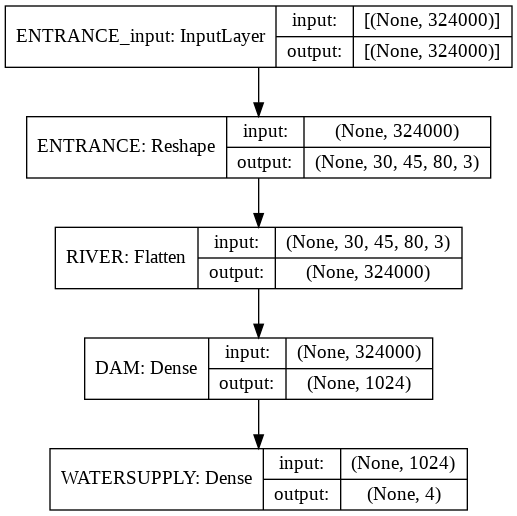

In [ ]:
#表示
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(
  model,
  show_shapes=True,
  )

# [A-4]学習

In [37]:
#@title 学習データ用意
import numpy as np

try:
  print(videos)
except:
  train_videos = np.load('/content/drive/MyDrive/colab/start/npVideos.npy')  
  train_labels = np.load('/content/drive/MyDrive/colab/start/npLabels.npy')  
  print("Use before data")
else:
  train_videos = fixed_videos.reshape(len(videos), input_allPattern).astype('float32')/255
  train_labels = []
  print("Use recent data")
  for video in videos:
    train_labels.append(LABEL[video.label])
  
  train_labels = tf.keras.utils.to_categorical(train_labels, 4)
  np.save('/content/desk/npVideos', train_videos)
  np.save('/content/desk/npLabels', train_labels)

Use before data


In [38]:
#@title 学習・学習評価設定
def learning(model, now):
  model.compile(optimizer='adam', 
                loss = 'categorical_crossentropy',
                metrics=['acc'])
  
  history = model.fit(
      train_videos, 
      train_labels, 
      batch_size=5,
      epochs=10
      )
  plotAcc(history, now)
  plotLoss(history, now)


import matplotlib.pyplot as plt
from pandas import DataFrame
import os

def plotAcc(history, now):
  fig = plt.figure()
  ACC = fig.add_subplot(1,1,1)

  props = {
      'title' : 'plot of ACCURACY',
      'xlabel' : 'epoch',
      'ylabel' : 'value',
      #  'ylim' : [0.2727,0.27275]
  }
  ACC.set(**props)

  acc = DataFrame(history.history['acc'])
  # val_acc = DataFrame(history.history['val_acc'])
  ACC.plot(acc, label='acc', marker='o', color='blue')
  # ACC.plot(val_acc, label='val_acc', marker='o', linestyle='--', color='orange')

  ACC.legend()

  #画像保存
  name_image = now + '_acc' 
  path_image = os.path.join('/content/desk', name_image)
  fig.savefig(path_image)

def plotLoss(history, now):
  fig = plt.figure()
  LOSS = fig.add_subplot(1,1,1)

  props = {
      'title' : 'plot of LOSS',
      'xlabel' : 'epoch',
      'ylabel' : 'value',
      # 'ylim' : [0, 0.01]
  }
  LOSS.set(**props)

  loss = DataFrame(history.history['loss'])
  # val_loss = DataFrame(history.history['val_loss'])
  LOSS.plot(loss, label='loss', marker='o', color='blue')
  # LOSS.plot(val_loss, label='val_loss', marker='o', linestyle='--', color='orange')

  LOSS.legend()

  #画像保存
  name_image = now + '_loss' 
  path_image= os.path.join('/content/desk', name_image)
  fig.savefig(path_image)

In [ ]:
#@title モデル用意
import os
name_model = 'key2.h5'
path_model = os.path.join('/content/desk/', name_model)

model = models.load_model(path_model)

## 学習

Epoch 1/10
26/26 [==============================] - 2s 71ms/step - loss: 5.1851 - acc: 0.3247
Epoch 2/10
26/26 [==============================] - 2s 71ms/step - loss: 3.1277 - acc: 0.3854
Epoch 3/10
26/26 [==============================] - 2s 71ms/step - loss: 1.4461 - acc: 0.2640
Epoch 4/10
26/26 [==============================] - 2s 71ms/step - loss: 1.3509 - acc: 0.3841
Epoch 5/10
26/26 [==============================] - 2s 71ms/step - loss: 1.2864 - acc: 0.4907
Epoch 6/10
26/26 [==============================] - 2s 72ms/step - loss: 1.3331 - acc: 0.4186
Epoch 7/10
26/26 [==============================] - 2s 71ms/step - loss: 1.3111 - acc: 0.4303
Epoch 8/10
26/26 [==============================] - 2s 71ms/step - loss: 1.3973 - acc: 0.3185
Epoch 9/10
26/26 [==============================] - 2s 71ms/step - loss: 1.7127 - acc: 0.2503
Epoch 10/10
26/26 [==============================] - 2s 71ms/step - loss: 1.4545 - acc: 0.2755


10783

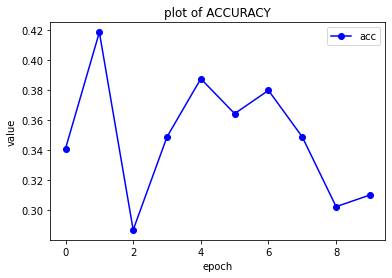

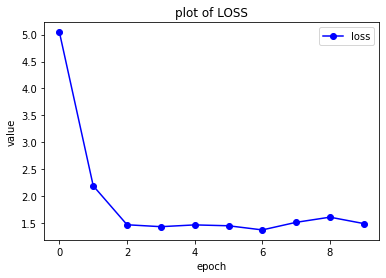

In [52]:
import datetime
import time

name_model = 'key3.h5'  
path_model = os.path.join('/content/desk/', name_model)

Model = models.load_model(path_model) 
dt_now_jst = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
dt_now_jst = dt_now_jst.strftime('%H!%M!%S')
learning(Model, dt_now_jst + 'key3')

del Model
import gc
gc.collect()

#test 

In [24]:
shelf = '/content/drive/MyDrive/colab/seed'
if not os.path.exists(shelf):
  os.mkdir(shelf)

In [20]:
wants = [
        'key1.h5',
        'key2.h5',
        'key3.h5'
]

In [31]:
import shutil
for want in wants:
  shutil.copy2(
      os.path.join(desk, want),
      os.path.join(shelf, want)
  )
              